In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftRandomForestClassifier

In [12]:
# Прочитаем файл с данными
raw_df = pd.read_csv("C:\SkillFactory\SF_DataScience\Current_tasks\data\DS_ADD_5\criteo-uplift-v2.1.csv")
raw_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [14]:
# Процентное соотношение признака показа рекламы
raw_df['treatment'].value_counts(normalize=True)

1    0.85
0    0.15
Name: treatment, dtype: float64

In [15]:
raw_df.groupby(['treatment', 'conversion']).agg({'conversion':[ 'count']})

conversion
                          count
treatment conversion           
0         0             2092874
          1                4063
1         0            11845944
          1               36711

In [16]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4',
                'f5', 'f6', 'f7', 'f8', 'f10', 'f11']

target_col = 'conversion'
treatment_col = 'treatment'

In [17]:
def target_class(df, treatment, target):
    
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    
    return df

In [18]:
raw_df = target_class(raw_df, treatment_col, target_col)
raw_df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0,2
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,2
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0,2
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2


In [19]:
# ! Важно
# Специально сокращаю объем тренировочных данных,
# чтобы была возможность завершить обучение (на полных данных обучение не завершается)
train_df, test_df = train_test_split(
    raw_df, 
    test_size=0.03, 
    random_state=42,
    stratify=raw_df[[treatment_col, target_col]]
)

train_df, val_df = train_test_split(
    train_df, 
    test_size=0.98, 
    random_state=42,
    stratify=train_df[[treatment_col, target_col]]
)

# ignor_df - объем данных, который исключается из рассмотрения
ignor_df, val_df = train_test_split(
    val_df,
    test_size=0.2,
    random_state=42
)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(271204, 17)
(419388, 17)
(2657800, 17)


In [20]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

### Построение модели S-learner (CausalML)

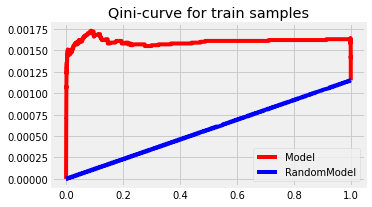

Qini score: 278.649


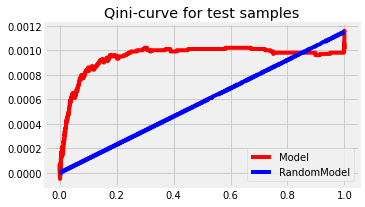

Qini score: 154.586


In [21]:
# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=42, verbose=0))

# Для обучения нам нужны датафрейм с факторами, колонка с фактом воздействия
s_learner.fit(X=train_df[feature_cols],
              treatment=train_df[treatment_col],
              y=train_df[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(train_df[feature_cols].values.copy()))
train_df['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(test_df[feature_cols].values.copy()))
test_df['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(train_df, title='train')
qini_df(test_df, title='test');

### Построение моедил T-learner (CausalML)

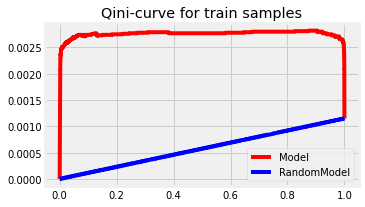

Qini score: 592.275


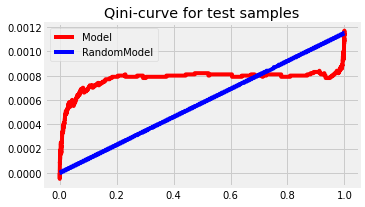

Qini score: 83.483


In [22]:
# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=42, verbose=0))

# Для обучения нам нужны датафрейм с факторами, колонка с фактом воздействия
t_learner.fit(X=train_df[feature_cols],
              treatment=train_df[treatment_col],
              y=train_df[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(train_df[feature_cols].values.copy()))
train_df['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(test_df[feature_cols].values.copy()))
test_df['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(train_df, title='train')
qini_df(test_df, title='test');

### Построение модели X-learner (CausalML)

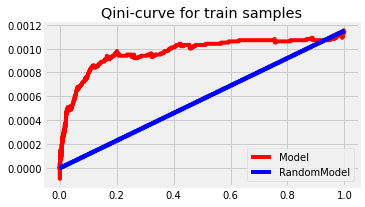

Qini score: 106.710


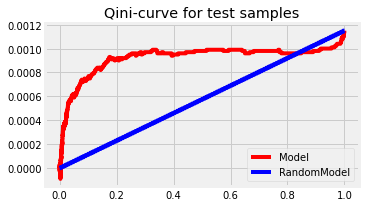

Qini score: 144.944


In [23]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=42, verbose=0),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(
    X=train_df[feature_cols],
    treatment=train_df[treatment_col],
    y=train_df[target_col],
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(train_df[feature_cols].values.copy()))
train_df['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(test_df[feature_cols].values.copy()))
test_df['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(train_df, title='train')
qini_df(test_df, title='test');

### Построение модели R-learner (CausalML)

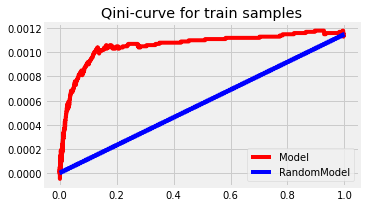

Qini score: 130.520


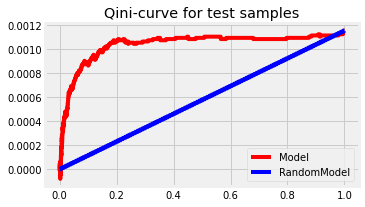

Qini score: 191.740


In [24]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(random_state=42, verbose=0),
    effect_learner=LinearRegression(),
    random_state=42
)

# Для обучения нам нужны датафрейм с факторами, колонка с фактом воздействия
r_learner.fit(X=train_df[feature_cols],
              treatment=train_df[treatment_col],
              y=train_df[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(train_df[feature_cols].values.copy()))
train_df['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(test_df[feature_cols].values.copy()))
test_df['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(train_df, title='train')
qini_df(test_df, title='test');

### Построение модели UpliftRandomForestClassifier (CausalML)

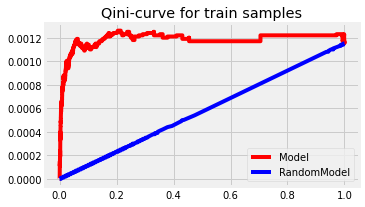

Qini score: 164.587


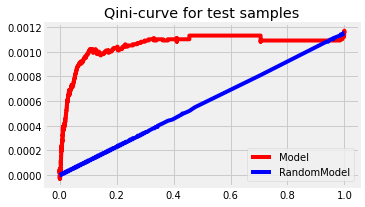

Qini score: 197.115


In [25]:
# Создаем простое дерево
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', control_name='0'
)

# Для обучения нам нужны датафрейм с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    train_df[feature_cols].values,
    treatment=train_df[treatment_col].apply(str).values,
    y=train_df[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = uplift_forest.predict(np.array(train_df[feature_cols].values.copy()))
train_df['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_forest.predict(np.array(test_df[feature_cols].values.copy()))
test_df['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(train_df, title='train')
qini_df(test_df, title='test')

### Сравнение моделей

In [26]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_score(df, title='train'):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    qini_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    return round(qini_score, 2)

In [27]:
Models = [
            ('S-learnear (Casual ML)', s_learner), 
            ('T-learnear (Casual ML)', t_learner), 
            ('X-learnear (Casual ML)', x_learner), 
            ('R-learnear (Casual ML)', r_learner), 
            ('UpliftRandomForestClassifier (Causal ML)', uplift_forest)
]

for (modelName, modelType) in Models:
    uplift_vals = modelType.predict(np.array(val_df[feature_cols].values.copy()))
    val_df['uplift_score'] = uplift_vals   
    print(f'{modelName}: qini score = {qini_score(val_df, title="validate")}')

S-learnear (Casual ML): qini score = 1077.61
T-learnear (Casual ML): qini score = 540.3
X-learnear (Casual ML): qini score = 1200.67
R-learnear (Casual ML): qini score = 1420.65
UpliftRandomForestClassifier (Causal ML): qini score = 1456.48


Вывод:
По результатам сравнения оценок по показателю qini_score наилучший результат показала модель Uplift Random Forest Classifier библиотеки Casual ML